In [2]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats

from scipy import ndimage
import numpy as np
import emd
from mne.decoding import SSD    

# Helper function for the second level sift
def mask_sift_second_layer(IA, masks, config={}):
    imf2 = np.zeros((IA.shape[0], IA.shape[1], config['max_imfs']))
    for ii in range(IA.shape[1]):
        config['mask_freqs'] = masks[ii:]
        tmp = emd.sift.mask_sift(IA[:, ii], **config)
        imf2[:, ii, :tmp.shape[1]] = tmp
    return imf2


In [2]:
%matplotlib qt

In [3]:

s=93
group = 'control'

filename = 'de_hokuto_%s%d-raw.fif'%(group, s)

raw=mne.io.read_raw_fif(filename)

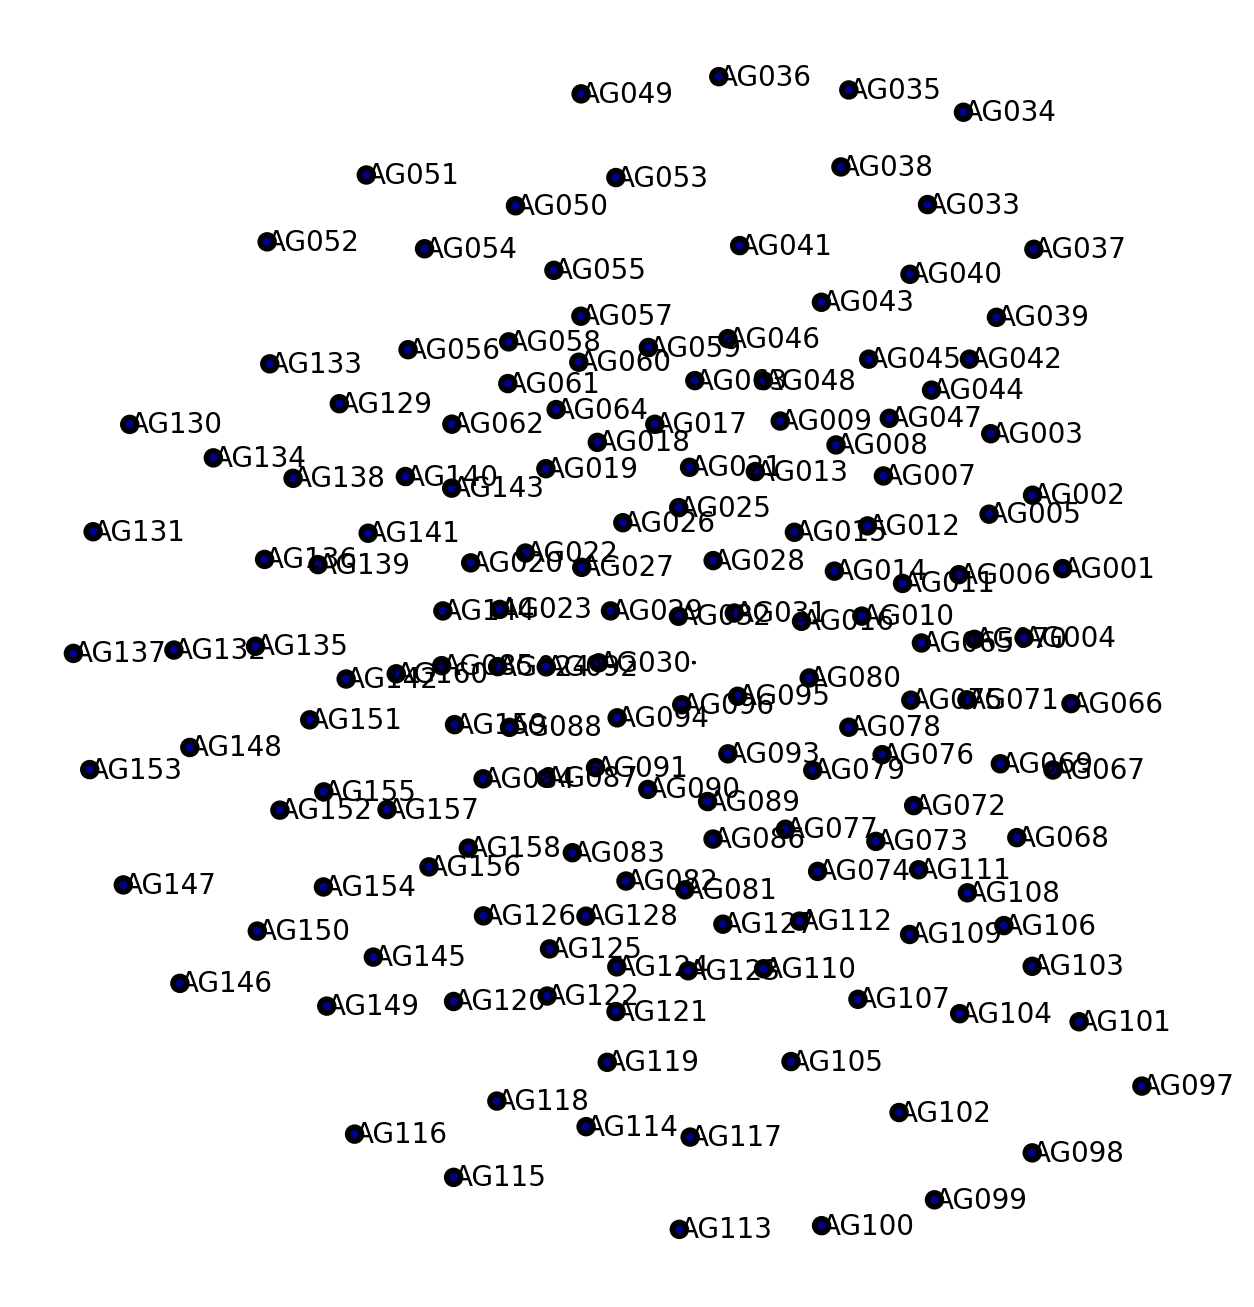

In [159]:
raw.plot_sensors(show_names=True)

/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_64277/2283658961.py:16: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_64277/2283658961.py:16: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  ssd.fit(X=epochs.get_data())


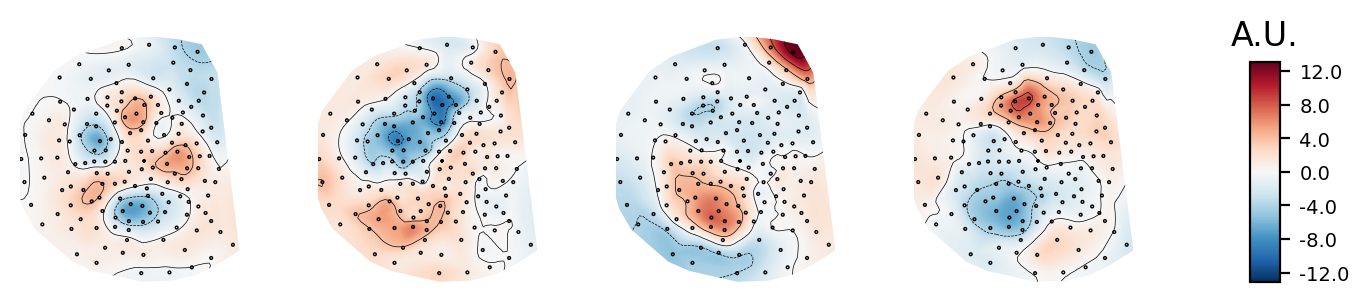

In [4]:
# find alpha
freqs_sig = 9, 12
freqs_noise = 8, 13

epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False)
epochs.drop_bad(reject = dict(mag=3e-12))      # unit: T (magnetometers)

ssd = SSD(info=raw.info,
          reg='oas',
          sort_by_spectral_ratio=False,  # False for purpose of example.
          n_components = 5,
          filt_params_signal=dict(l_freq=freqs_sig[0], h_freq=freqs_sig[1],
                                  l_trans_bandwidth=1, h_trans_bandwidth=1),
          filt_params_noise=dict(l_freq=freqs_noise[0], h_freq=freqs_noise[1],
                                 l_trans_bandwidth=1, h_trans_bandwidth=1))
ssd.fit(X=epochs.get_data())

pattern = mne.EvokedArray(data=ssd.patterns_[:4].T,
                          info=ssd.info)
pattern.plot_topomap(units=dict(mag='A.U.'), time_format='')

In [41]:
epochs.get_data().shape[0]

115

In [14]:


fig, ax = plt.subplots()
data_to_plot = ssd.patterns_[0]
b = stats.zscore(data_to_plot)
mne.viz.plot_topomap(b, raw.info,extrapolate='head',axes=ax, vmin=-3, vmax=3, sensors=False, contours=0)
fig.tight_layout()

In [21]:
ssd_sources = ssd.transform(X=raw.get_data())

# Get psd of SSD-filtered signals.
psd, freqs = mne.time_frequency.psd_array_welch(
    ssd_sources, sfreq=raw.info['sfreq'], n_fft=4096, fmin=9, fmax=10)

In [24]:
b = stats.zscore(psd.mean(axis=1))
mne.viz.plot_topomap(b, raw.info,extrapolate='head',axes=ax, vmin=-3, vmax=3, sensors=False, contours=0)
fig.tight_layout()

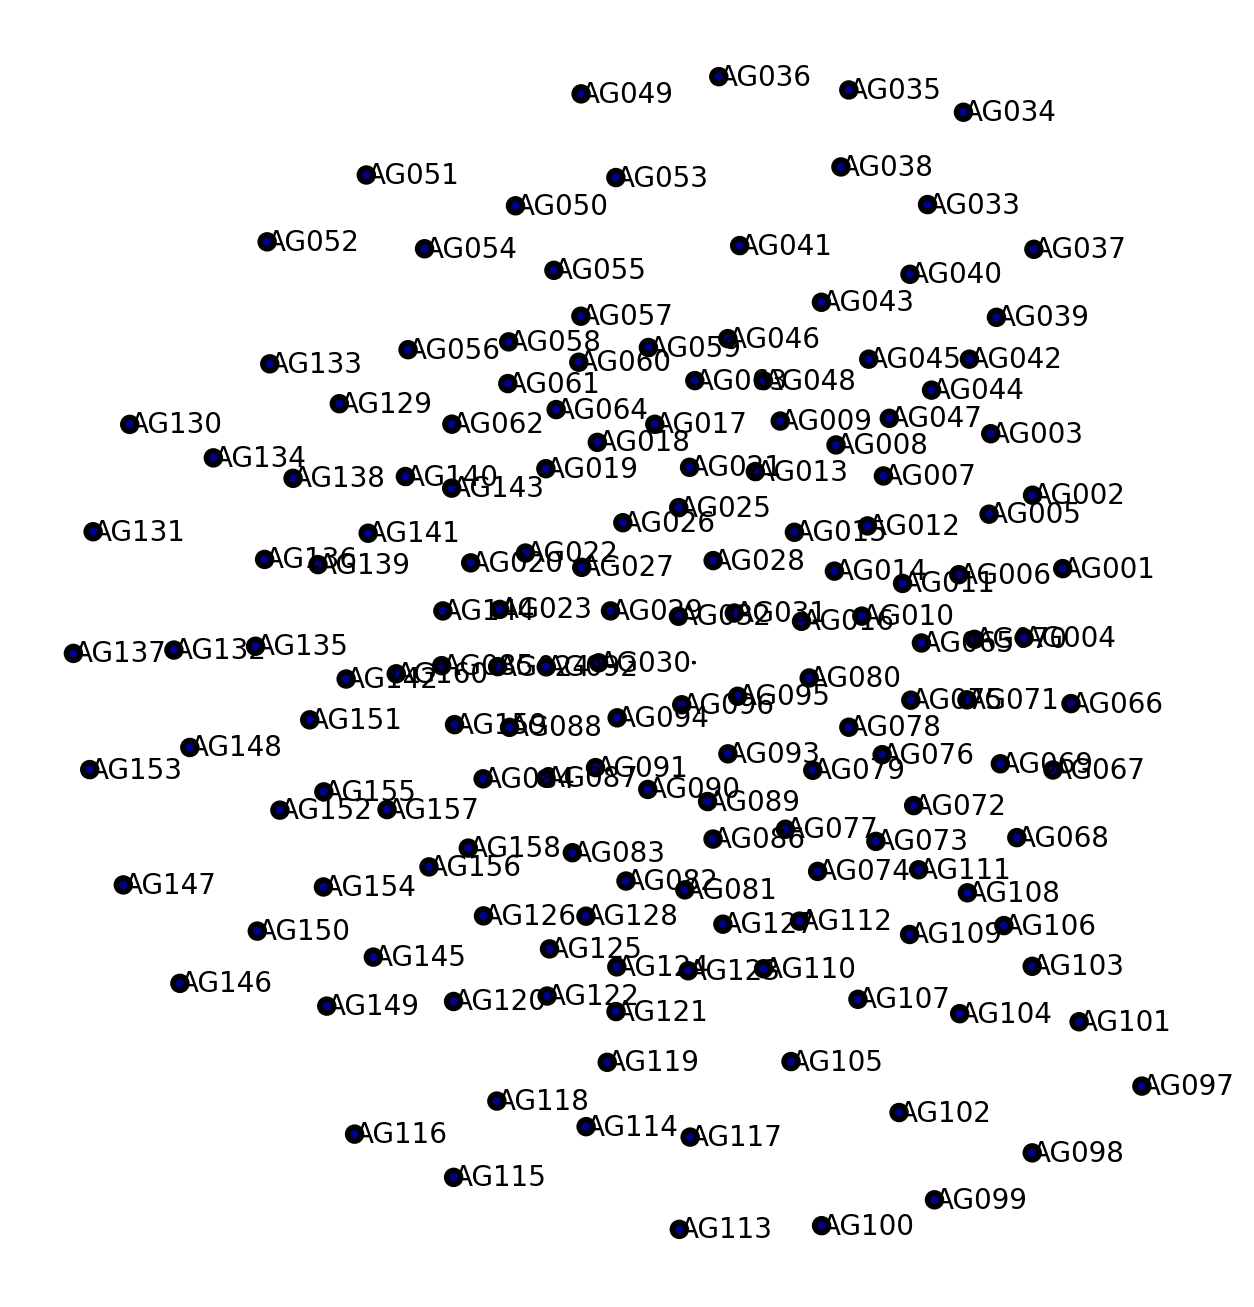

In [25]:
raw.plot_sensors(show_names=True)

In [5]:
idx = np.argmax(np.abs(ssd.patterns_[0]))
name_ = raw.info['ch_names'][idx]
epochs.load_data()
x = epochs.copy().pick_channels([name_]).get_data()
x = np.squeeze(x) * 1e+15
x.shape

(115, 1000)

In [44]:
n_trl = epochs.get_data().shape[0]
sholo_temp = np.zeros((n_trl, 256, 128))

sample_rate = np.int(raw.info['sfreq'])
config = emd.sift.get_config('mask_sift')
config['max_imfs'] = 7
config['mask_freqs'] = 50/sample_rate
config['mask_amp_mode'] = 'ratio_sig'
config['imf_opts/sd_thresh'] = 0.05

for n in range(n_trl):
    imf = emd.sift.mask_sift(x[n], **config)
    IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
    masks = np.array([25/2**ii for ii in range(12)])/sample_rate
    config = emd.sift.get_config('mask_sift')
    config['mask_amp_mode'] = 'ratio_sig'
    config['mask_amp'] = 2
    config['max_imfs'] = 5
    config['imf_opts/sd_thresh'] = 0.05
    config['envelope_opts/interp_method'] = 'mono_pchip'

    # Sift the first 5 first level IMFs
    imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)
    
    IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')
    fcarrier, fam, holo = emd.spectra.holospectrum(IF[:,0:6], IF2[:,0:6,:], IA2[:,0:6,:], carrier_hist, am_hist)
    sholo = ndimage.gaussian_filter(holo, 1)
    
    sholo_temp[n] = sholo
    pass

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_64277/385657721.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_rate = np.int(raw.info['sfreq'])


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recogn

In [7]:


# Define sift parameters for the second level
masks = np.array([25/2**ii for ii in range(12)])/sample_rate
config = emd.sift.get_config('mask_sift')
config['mask_amp_mode'] = 'ratio_sig'
config['mask_amp'] = 2
config['max_imfs'] = 5
config['imf_opts/sd_thresh'] = 0.05
config['envelope_opts/interp_method'] = 'mono_pchip'

# Sift the first 5 first level IMFs
imf2 = emd.sift.mask_sift_second_layer(IA, masks, sift_args=config)

 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged
 Logger level 'None' not recognised - level is unchanged


In [46]:
print(sholo_temp.shape)
print(IF2.shape)
print(IA2.shape)

(115, 256, 128)
(1000, 5, 5)
(1000, 5, 5)


In [26]:
IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')
fcarrier, fam, holo = emd.spectra.holospectrum(IF[:,0:6], IF2[:,0:6,:], IA2[:,0:6,:], carrier_hist, am_hist)
sholo = ndimage.gaussian_filter(holo, 1)


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


In [49]:
sholo_m = np.squeeze(sholo_temp.mean(axis = 0))
fig, ax = plt.subplots()
ax.pcolormesh(fam, fcarrier, sholo_m, cmap='hot_r', shading='nearest')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('raw.plot()')

Text(0.5, 1.0, 'raw.plot()')

In [29]:
IP2, IF2, IA2 = emd.spectra.frequency_transform(imf2, sample_rate, 'nht')

# Carrier frequency histogram definition
carrier_hist = (1, 100, 256, 'log')
# AM frequency histogram definition
am_hist = (1e-2, 32, 128, 'log')

# Compute the 1d Hilbert-Huang transform (power over carrier frequency)
fcarrier, spec = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_imfs=False)

# Compute the 2d Hilbert-Huang transform (power over time x carrier frequency)
fcarrier, hht = emd.spectra.hilberthuang(IF, IA, carrier_hist, sum_time=False)
shht = ndimage.gaussian_filter(hht, 2)

# Compute the 3d Holospectrum transform (power over time x carrier frequency x AM frequency)
# Here we return the time averaged Holospectrum (power over carrier frequency x AM frequency)
fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, carrier_hist, am_hist)
sholo = ndimage.gaussian_filter(holo, 1)

plt.pcolormesh(fam, fcarrier, sholo, cmap='hot_r', shading='nearest')
plt.yscale('log')
plt.xscale('log')
plt.title('Holospectrum')
plt.xlabel('AM Frequency (Hz)')
plt.yticks(2**np.arange(8), 2**np.arange(8))
plt.xticks([.1, .5, 1, 2, 4, 8, 16, 32, 64], [.1, .5, 1, 2, 4, 8, 16, 32, 64])


/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/numpy/lib/function_base.py:1540: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
/Users/kevinhsu/anaconda3/envs/mne/lib/python3.9/site-packages/emd/utils.py:297: RuntimeWarning: invalid value encountered in remainder
  phases = (IP) % (ncycles * 2 * np.pi)


ValueError: invalid entry in coordinates array

In [55]:
freq_edges, freq_centres = emd.spectra.define_hist_bins(1, 75, 75, 'log')
freq_edges_low, freq_centres_low = emd.spectra.define_hist_bins(2, 10, 20, 'linear')

fcarrier, fam, holo = emd.spectra.holospectrum(IF, IF2, IA2, freq_edges, freq_edges_low)

plt.pcolormesh(freq_centres_low, freq_centres, holo, cmap='hot_r', shading='auto')
plt.xticks(np.arange(3, 10, 2))
plt.title('Sinusoidal AM')


[ 1.          1.05925572  1.12202268  1.18850893  1.25893488  1.33353397
  1.41255349  1.49625536  1.58491704  1.67883244  1.77831286  1.88368806
  1.99530735  2.11354072  2.23878009  2.37144061  2.51196202  2.66081014
  2.81847835  2.98548931  3.16239662  3.3497867   3.54828071  3.75853663
  3.98125142  4.21716333  4.46705437  4.73175288  5.01213629  5.30913402
  5.62373057  5.95696876  6.30995321  6.68385402  7.07991058  7.49943576
  7.94382021  8.41453698  8.9131464   9.44130129 10.00075237 10.59335413
 11.22107093 11.88598354 12.59029602 13.33634304 14.12659762 14.96367929
 15.85036285 16.78958747 17.78446652 18.83829785 19.9545747  21.13699734
 22.38948529 23.7161903  25.12151017 26.61010328 28.18690404 29.85713927
 31.62634548 33.50038727 35.48547675 37.58819414 39.81550955 42.17480613
 44.67390453 47.3210888  50.12513387 53.09533464 56.24153679 59.5741694
 63.10427955 66.84356891 70.80443255 75.        ]
[ 2.   2.4  2.8  3.2  3.6  4.   4.4  4.8  5.2  5.6  6.   6.4  6.8  7.2
  7.

ValueError: invalid entry in coordinates array

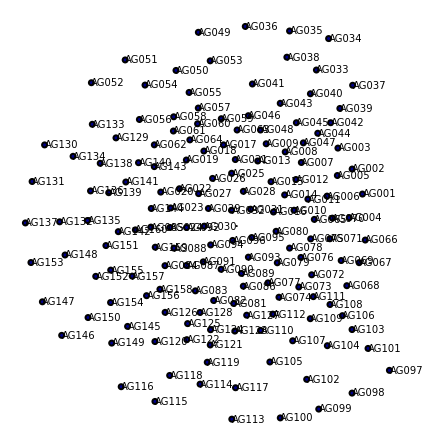

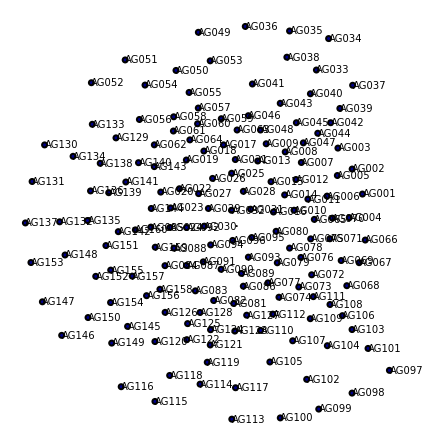

In [7]:
raw.plot_sensors(show_names=True)

Opening raw data file hokuto_test42-raw.fif...
Isotrak not found
    Range : 0 ... 599999 =      0.000 ...   300.000 secs
Ready.
Effective window size : 1.024 (s)


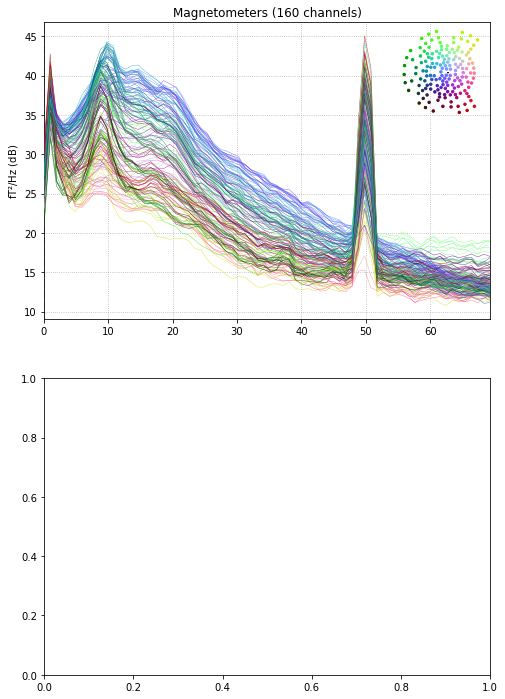

Reading 0 ... 599999  =      0.000 ...   300.000 secs...
Writing /Users/kevinhsu/Documents/D/00_datasets/biomag_2022/de_hokuto_test42-raw.fif
Closing /Users/kevinhsu/Documents/D/00_datasets/biomag_2022/de_hokuto_test42-raw.fif
[done]
Effective window size : 4.096 (s)


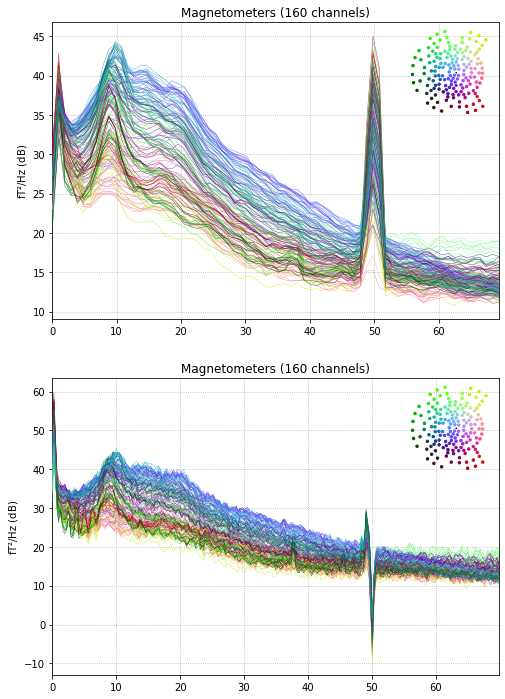

In [54]:

s=42
#need_notch = False
need_notch = True

group = 'test'

filename = 'hokuto_%s%d-raw.fif'%(group, s)

raw=mne.io.read_raw_fif(filename)

if raw.info['sfreq'] == 1000.0:
    ag_num = ['037','033','034','039','042','040','101','097','103','104','098','138','141','136','139','135','142','151','152','155','157','154']

if raw.info['sfreq'] == 2000.0:
    ag_num = ['035','036','039','038','042','044','101','100','104','105','108','109','155','137','153','142','140','143','154','156','157']

fig, ax = plt.subplots(2, figsize=(8, 12))

raw.plot_psd(0, 70, ax=ax[0])

raw.load_data()

if need_notch == True:
    raw.filter(0, 200, phase= 'zero-double', verbose=False)
    raw.notch_filter(50, n_jobs=2, verbose=False)
    raw=raw.resample(sfreq=500,n_jobs=2, verbose=False)
else:
    raw.filter(0, 200, phase= 'zero-double', verbose=False)
    raw=raw.resample(sfreq=500, n_jobs=2, verbose=False)

# 不做 ICA
filename = 'de_hokuto_%s%d-raw.fif'%(group, s)
raw.save(filename, overwrite=True)

raw.plot_psd(0, 70, ax=ax[1])

Fitting ICA to data using 160 channels (please be patient, this may take a while)


/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_46297/2154188957.py:11: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=n_components,
/var/folders/7w/cb7mhl253wdbc67t80fs_bmc0000gn/T/ipykernel_46297/2154188957.py:14: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw, decim=decim, picks=picks)


Selecting by number: 15 components
 
Fitting ICA took 7.1s.


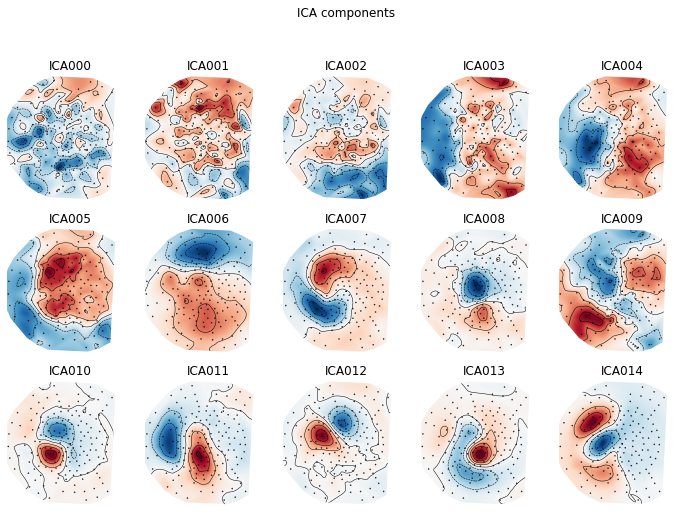

Creating RawArray with float64 data, n_channels=15, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   299.998 secs
Ready.


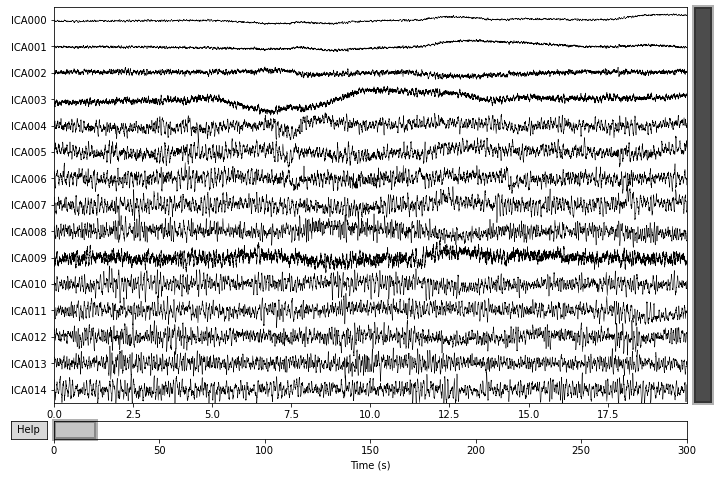

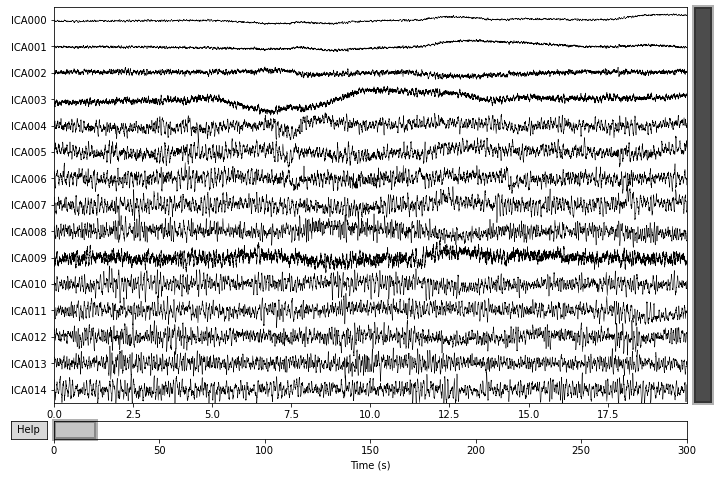

In [55]:

method = 'infomax'  #old ver: 'extended-infomax'
n_components = 15 # dementia12:30, dementia18:30

max_pca_components = 15
random_state = 23

decim = 3

picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False,ecg=False, exclude='bads')

ica = ICA(n_components=n_components,  
          random_state=random_state, method=method) #old ver: max_pca_components=max_pca_components,

ica.fit(raw, decim=decim, picks=picks)

ica.plot_components() #ica.plot_components(layout = kit_lay)

ica.plot_sources(raw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 160 PCA components


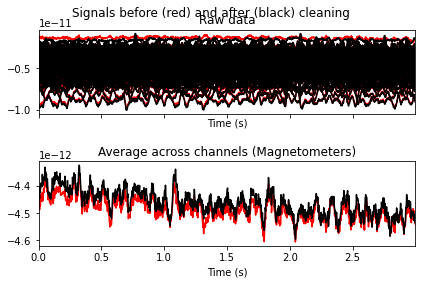

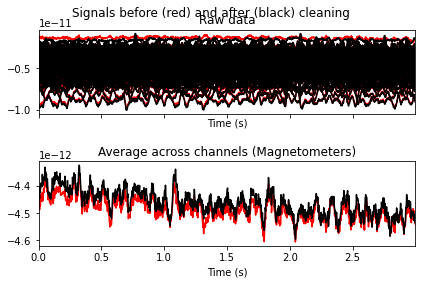

In [56]:
#check how well it works if certain features are removed.

exclude_ic = [3]

ica.plot_overlay(raw, exclude = exclude_ic)



Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 160 PCA components
Overwriting existing file.
Writing /Users/kevinhsu/Documents/D/00_datasets/biomag_2022/de_hokuto_test42-raw.fif
Closing /Users/kevinhsu/Documents/D/00_datasets/biomag_2022/de_hokuto_test42-raw.fif
[done]


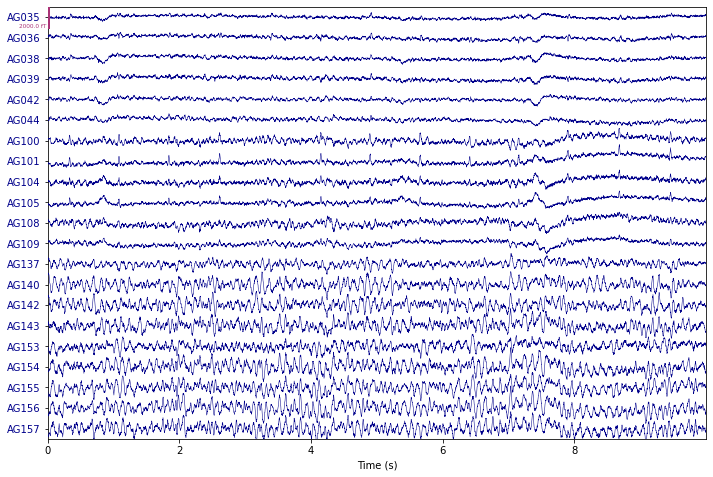

In [57]:
reconst_raw = raw.copy()

ica.apply(reconst_raw, exclude = exclude_ic)

filename = 'de_hokuto_%s%d-raw.fif'%(group, s)
reconst_raw.save(filename, overwrite=True)

ag_names = ['AG'+s for s in ag_num]
ag_picks = mne.pick_channels(raw.ch_names, ag_names)
fig_raw = reconst_raw.plot(order=ag_picks, n_channels=len(ag_picks),
     show_scrollbars=False, show=False)

In [139]:
# 不做 ICA
filename = 'de_hokuto_%s%d-raw.fif'%(group, s)
raw.save(filename, overwrite=True)


Effective window size : 4.096 (s)


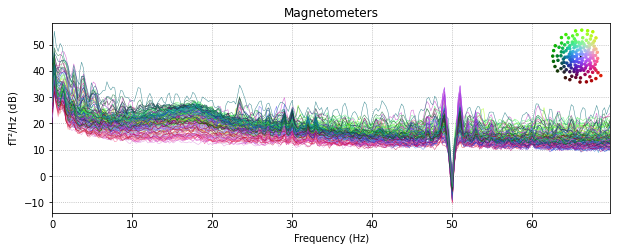

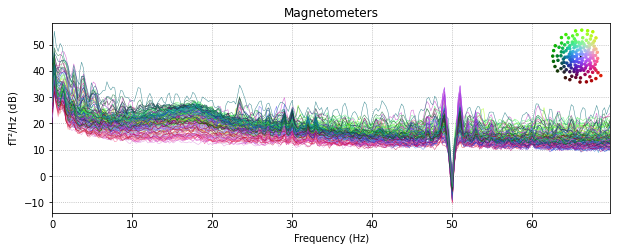

In [46]:
reconst_raw.plot_psd(0, 70)